# **Chest X-Ray Medical Diagnosis with Deep Learning**

This is a neural network to detect Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, Nodule, Pleural Thickening, Pneumonia and Pneumothorax in Chest X-Rays.
The data used here is a subset of ChestX-ray8 dataset. The images have already been divided into training, development and test sets to avoid Data Leakage.

## Let us import Packages 
For this neural network, we will make use of a pre-trained model DenseNet121 for transfer learning. 

In [6]:
%tensorflow_version 1.x

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model


## Then, let us import data which is in csv format

In [17]:
train_df = pd.read_csv("/home/train.csv")
valid_df = pd.read_csv("/home/dev.csv")
test_df = pd.read_csv("/home/test.csv")

Here is a sample of the csv file

In [18]:
test_df.head()

,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [19]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis','Pneumothorax','Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

## Let us now process the images
Using the ImageDataGenerator class from Keras framework

In [20]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=10, seed=1, target_w = 320, target_h = 320):         
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [37]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
   
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [42]:
IMAGE_DIR ="/home/Images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

Found 1000 validated image filenames.
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 1000 validated image filenames.


Let us look at one of the processed images now

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


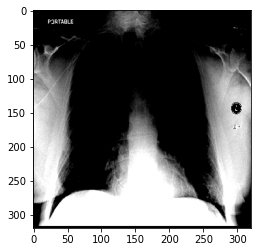

In [24]:
x, y = train_generator.__getitem__(5)
plt.imshow(x[5]);

# Now, we have to train the model

Before we start training let us look at the number of samples of each class.

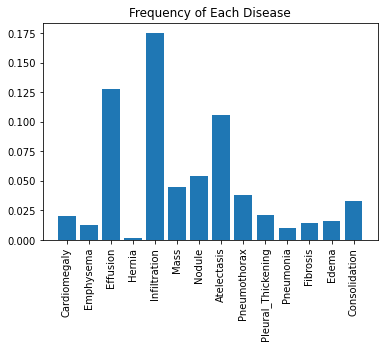

In [25]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Disease")
plt.show()

The contribution of each disease to the Loss Function is unequal.

In [26]:
def compute_class_freqs(labels):
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = np.sum(labels==0, axis=0) / N
    
    return positive_frequencies, negative_frequencies


In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

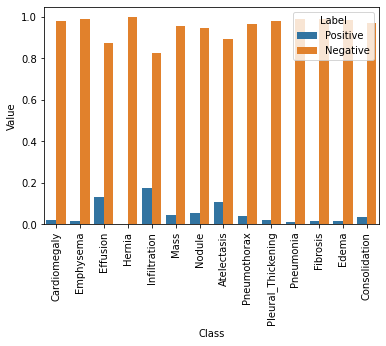

In [56]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Since there is a huge difference in contribution of positive and negative samples to the loss function, we cannot use a normal function like cross-entropy function. Instead, let's use the weighted loss function:
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [28]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

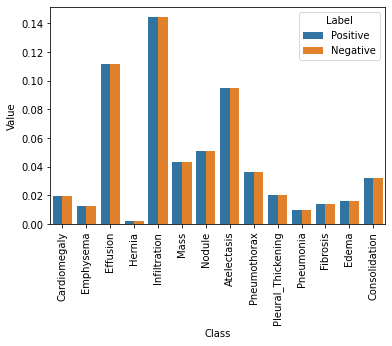

In [29]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

We can clearly see now that the negative and positive samples contribute equally to the loss function

In [30]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)): 
            loss += -1 * K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) + 
                     neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon)))
        return loss
        
    return weighted_loss

Let us now use DenseNet121 to load convolutional layers. 

In [ ]:
base_model = DenseNet121(weights='/home/densenet.hdf5', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

### Training the model:

Epoch 1/100
100/100 [==============================] - 36s 359ms/step - loss: 0.8655 - val_loss: 1.2184
Epoch 2/100
100/100 [==============================] - 33s 326ms/step - loss: 0.8555 - val_loss: 15.0264
Epoch 3/100
100/100 [==============================] - 32s 324ms/step - loss: 0.8913 - val_loss: 8.7213
Epoch 4/100
100/100 [==============================] - 33s 328ms/step - loss: 0.8689 - val_loss: 9.0522
Epoch 5/100
100/100 [==============================] - 33s 329ms/step - loss: 0.8447 - val_loss: 3.3552
Epoch 6/100
100/100 [==============================] - 32s 325ms/step - loss: 0.8606 - val_loss: 5.4403
Epoch 7/100
100/100 [==============================] - 33s 330ms/step - loss: 0.8302 - val_loss: 1.1901
Epoch 8/100
100/100 [==============================] - 33s 326ms/step - loss: 0.8405 - val_loss: 1.2406
Epoch 9/100
100/100 [==============================] - 33s 325ms/step - loss: 0.8318 - val_loss: 5.1093
Epoch 10/100
100/100 [==============================] - 33s 328

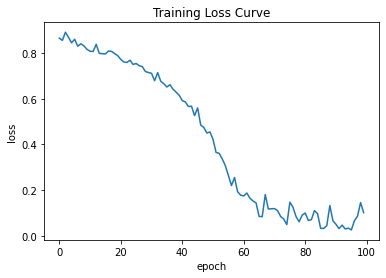

In [34]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 100)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

I ran the model for a total of 100 epochs which took me about 55 minutes.

### Let us now calculate the accuracy of the model

In [54]:
accuracy=model.evaluate_generator(test_generator,steps=len(test_generator))

In [55]:
print("Accuracy=", accuracy)

Accuracy= 0.9643886685371399


# The model has an accuracy of 96.438%!